<a href="https://colab.research.google.com/github/pbgg98/SU2/blob/master/predicting_remaining_life_of_nasa_turbofan_engines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Remaining Life of NASA Turbofan Engines

<style>
.MathJax {
  font-family: "HTML-CSS";
}
</style>

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$


__<div style="text-align: right"> LEO6006: Data Science and Machine Learning for Aerospace Systems, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

---

<br>

<center>
<img src="https://jonghank.github.io/leo6006/files/f100.jpg" width="600">
</center>


<br>

**Description**

Prognostics and health management is an important topic in industry for predicting state of assets to avoid downtime and failures. This data set is the Kaggle version of the very well known public data set for asset degradation modeling from NASA. It includes Run-to-Failure simulated data from turbo fan jet engines.

Engine degradation simulation was carried out using C-MAPSS. Four different were sets simulated under different combinations of operational conditions and fault modes. Records several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

<br>

**Prediction Goal**

In this dataset the goal is to predict the remaining useful life (RUL) of each engine in the test dataset. RUL is equivalent of number of flights remained for the engine after the last datapoint in the test dataset.

<br>

**Experimental Scenario**

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

<br>

1) unit number

2) time, in cycles

3) operational setting 1

4) operational setting 2

5) operational setting 3

6) sensor measurement 1

7) sensor measurement 2

…

26) sensor measurement 26

<br>

**Data Set Organization**

**Data Set: FD001**
 - Train trjectories: 100
 - Test trajectories: 100
 - Conditions: ONE (Sea Level)
 - Fault Modes: ONE (HPC Degradation)

**Data Set: FD002**
 - Train trjectories: 260
 - Test trajectories: 259
 - Conditions: SIX
 - Fault Modes: ONE (HPC Degradation)

**Data Set: FD003**
 - Train trjectories: 100
 - Test trajectories: 100
 - Conditions: ONE (Sea Level)
 - Fault Modes: TWO (HPC Degradation, Fan Degradation)

**Data Set: FD004**
 - Train trjectories: 248
 - Test trajectories: 249
 - Conditions: SIX
 - Fault Modes: TWO (HPC Degradation, Fan Degradation)

<br>

**Reference**

A. Saxena, K. Goebel, D. Simon, and N. Eklund, Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

<br>

In [1]:
import kagglehub
behrad3d_nasa_cmaps_path = kagglehub.dataset_download('behrad3d/nasa-cmaps')

print('Data source import complete.')

Data source import complete.


In [2]:
# Import the libraries required for exploration and preproccesing
import numpy as np
import pandas as pd

from IPython.display import display, HTML

import matplotlib.pyplot as plt
import seaborn as sns

# Configure Jupyter Notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.expand_frame_repr', False)#표 출력양식 변경
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

In [3]:
# Give names to the features
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names

df_train = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test_RUL = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

<br>

First up is just to eyeball the data.

The training data set has data up to the point of failure, therefore the maximum cycle for each engine was the life that was achieved by the engine.

In the training set, the data has not yet reached the point of failure, therefore the RUL file will tell us how much time still remained until failure. We'll form our predictions against this value

In [4]:
df_train

,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(Engine pressure ratio(P50/P2),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [5]:
df_test

,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(Engine pressure ratio(P50/P2),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   20631 non-null  int64  
 1   cycle                                    20631 non-null  int64  
 2   setting_1                                20631 non-null  float64
 3   setting_2                                20631 non-null  float64
 4   setting_3                                20631 non-null  float64
 5   (Fan inlet temperature) (◦R)             20631 non-null  float64
 6   (LPC outlet temperature) (◦R)            20631 non-null  float64
 7   (HPC outlet temperature) (◦R)            20631 non-null  float64
 8   (LPT outlet temperature) (◦R)            20631 non-null  float64
 9   (Fan inlet Pressure) (psia)              20631 non-null  float64
 10  (bypass-duct pressure) (psia)            20631

In [7]:
df_train.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
(Fan inlet temperature) (◦R),20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
(LPC outlet temperature) (◦R),20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
(HPC outlet temperature) (◦R),20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
(LPT outlet temperature) (◦R),20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
(Fan inlet Pressure) (psia),20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


In [8]:
df_test_RUL.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
RUL,112,98,69,82,91,93,91,95,111,96,97,124,95,107,83,84,50,28,87,16,57,111,113,20,145,119,66,97,90,115,8,48,106,7,11,19,21,50,142,28,18,10,59,109,114,47,135,92,21,79,114,29,26,97,137,15,103,37,114,100,21,54,72,28,128,14,77,8,121,94,118,50,131,126,113,10,34,107,63,90,8,9,137,58,118,89,116,115,136,28,38,20,85,55,128,137,82,59,117,20


<br>

We find the correlations for the features

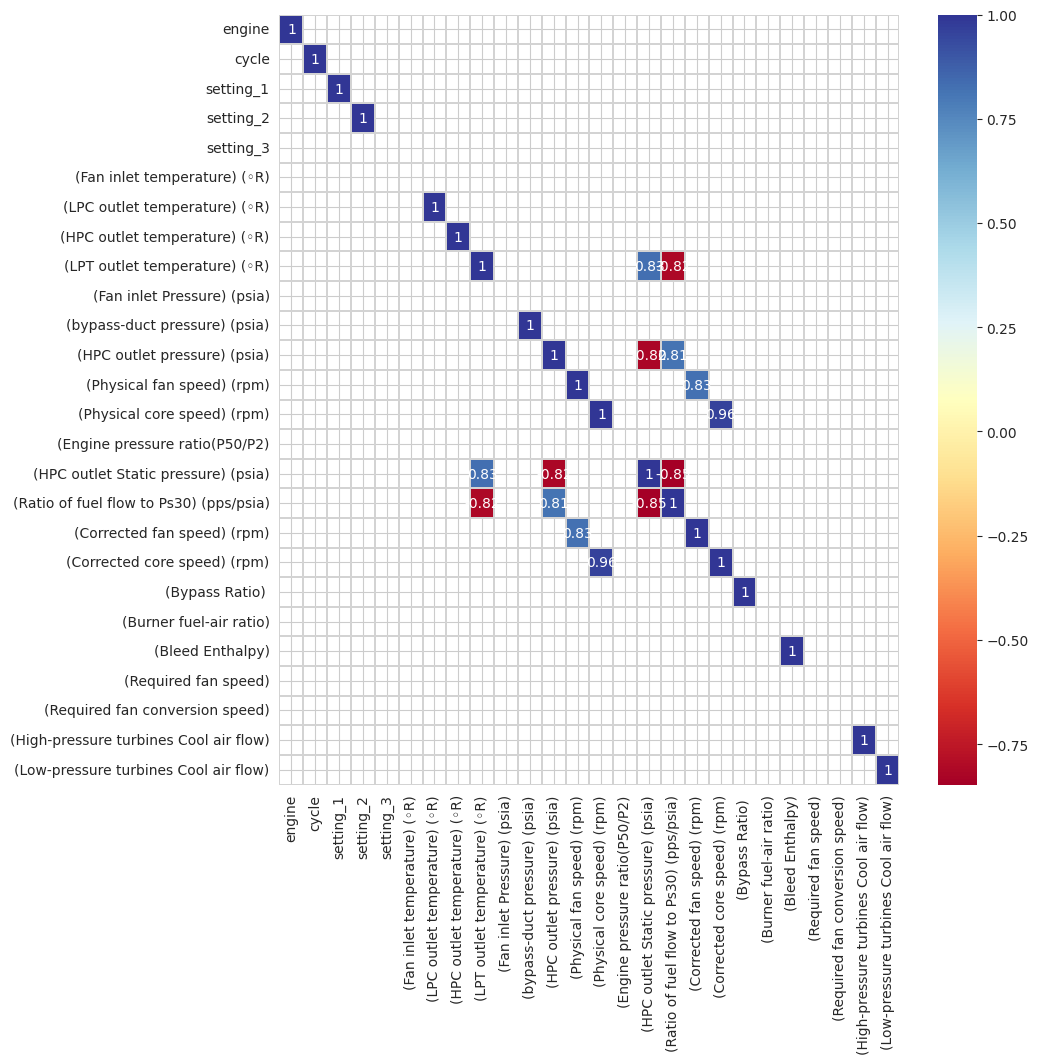

In [9]:
plt.figure(figsize=(10,10))
threshold = 0.8
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2,
            linecolor='lightgrey').set_facecolor('white')

Sensors with constant values can be dropped as they have no predictive power

In [10]:
# drop the sensors wiith constant values
sens_const_values = []
for feature in list(setting_names + sensor_names):
    try:
        if df_train[feature].min()==df_train[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)
df_train.drop(sens_const_values,axis=1,inplace=True)
df_test.drop(sens_const_values,axis=1,inplace=True)

['setting_3', '(Fan inlet temperature) (◦R)', '(Fan inlet Pressure) (psia)', '(Engine pressure ratio(P50/P2)', '(Burner fuel-air ratio)', '(Required fan speed)', '(Required fan conversion speed)']


Drop one of the highly correlated features and keep the other. The threshold for correlation is set at 0.95

In [11]:
# drop all but one of the highly correlated features
cor_matrix = df_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(corr_features)
df_train.drop(corr_features,axis=1,inplace=True)
df_test.drop(corr_features,axis=1,inplace=True)

['(Corrected core speed) (rpm)']


The remaining features

In [12]:
list(df_train)

['engine',
 'cycle',
 'setting_1',
 'setting_2',
 '(LPC outlet temperature) (◦R)',
 '(HPC outlet temperature) (◦R)',
 '(LPT outlet temperature) (◦R)',
 '(bypass-duct pressure) (psia)',
 '(HPC outlet pressure) (psia)',
 '(Physical fan speed) (rpm)',
 '(Physical core speed) (rpm)',
 '(HPC outlet Static pressure) (psia)',
 '(Ratio of fuel flow to Ps30) (pps/psia)',
 '(Corrected fan speed) (rpm)',
 '(Bypass Ratio) ',
 '(Bleed Enthalpy)',
 '(High-pressure turbines Cool air flow)',
 '(Low-pressure turbines Cool air flow)']

In [13]:
df_train

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640


In [14]:
features = list(df_train.columns)

In [15]:
# check for missing data
for feature in features:
    print(feature + " - " + str(len(df_train[df_train[feature].isna()])))

engine - 0
cycle - 0
setting_1 - 0
setting_2 - 0
(LPC outlet temperature) (◦R) - 0
(HPC outlet temperature) (◦R) - 0
(LPT outlet temperature) (◦R) - 0
(bypass-duct pressure) (psia) - 0
(HPC outlet pressure) (psia) - 0
(Physical fan speed) (rpm) - 0
(Physical core speed) (rpm) - 0
(HPC outlet Static pressure) (psia) - 0
(Ratio of fuel flow to Ps30) (pps/psia) - 0
(Corrected fan speed) (rpm) - 0
(Bypass Ratio)  - 0
(Bleed Enthalpy) - 0
(High-pressure turbines Cool air flow) - 0
(Low-pressure turbines Cool air flow) - 0


Add the RUL as a target feature to the data

In [16]:
# define the maximum life of each engine, as this could be used to obtain the RUL at each point in time of the engine's life
df_train_RUL = df_train.groupby(['engine']).agg({'cycle':'max'})
df_train_RUL.rename(columns={'cycle':'life'},inplace=True)
df_train_RUL.T

engine,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
life,192,287,179,189,269,188,259,150,201,222,240,170,163,180,207,209,276,195,158,234,195,202,168,147,230,199,156,165,163,194,234,191,200,195,181,158,170,194,128,188,216,196,207,192,158,256,214,231,215,198,213,213,195,257,193,275,137,147,231,172,185,180,174,283,153,202,313,199,362,137,208,213,213,166,229,210,154,231,199,185,240,214,293,267,188,278,178,213,217,154,135,341,155,258,283,336,202,156,185,200


In [17]:
df_test_life = df_test.groupby(['engine']).agg({'cycle':'max'})
df_test_life.rename(columns={'cycle':'life'},inplace=True)
df_test_life['life'] = df_test_life['life'].values + df_test_RUL.values.flatten()
df_test_RUL = df_test_life.copy()
df_test_RUL.T

engine,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
life,143,147,195,188,189,198,251,261,166,288,180,341,290,153,159,197,215,161,222,200,205,150,243,206,193,195,206,255,261,258,204,193,156,210,209,145,142,175,179,161,141,166,231,163,266,193,208,170,324,153,258,218,190,218,250,151,263,213,208,247,180,286,227,196,199,161,148,195,175,246,186,181,243,263,201,215,196,179,164,223,221,171,210,230,152,199,172,183,313,174,272,170,329,188,217,234,216,180,214,218


In [18]:
df_train=df_train.merge(df_train_RUL,how='left',on=['engine'])
df_train

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),life
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,192
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,192
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,192
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,200
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,200
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,200
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,200


In [19]:
df_test=df_test.merge(df_test_RUL,how='left',on=['engine'])
df_test

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),life
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8.4052,392,38.86,23.3735,143
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8.3803,393,39.02,23.3916,143
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8.4441,393,39.08,23.4166,143
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8.3917,391,39.00,23.3737,143
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8.4031,390,38.99,23.4130,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,9142.37,47.69,520.69,2388.00,8.4715,394,38.65,23.1974,218
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,9140.68,47.60,521.05,2388.09,8.4512,395,38.57,23.2771,218
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,9146.81,47.57,521.18,2388.04,8.4569,395,38.62,23.2051,218
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,9148.85,47.61,521.33,2388.08,8.4711,395,38.66,23.2699,218


In [20]:
df_train['RUL']=df_train['life']-df_train['cycle']
df_train.drop(['life'],axis=1,inplace=True)

df_test['RUL']=df_test['life']-df_test['cycle']
df_test.drop(['life'],axis=1,inplace=True)

# the RUL prediction is only useful nearer to the end of the engine's life, therefore we put an upper limit on the RUL
# this is a bit sneaky, since it supposes that the test set has RULs of less than this value, the closer you are
# to the true value, the more accurate the model will be
#df_train['RUL'][df_train['RUL']>125]=125

In [21]:
df_train

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1


In [22]:
df_test

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8.4031,390,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,9142.37,47.69,520.69,2388.00,8.4715,394,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,9140.68,47.60,521.05,2388.09,8.4512,395,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,9146.81,47.57,521.18,2388.04,8.4569,395,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,9148.85,47.61,521.33,2388.08,8.4711,395,38.66,23.2699,21


In [23]:
X_train = df_train.iloc[:,2:-1]
y_train = df_train.iloc[:,-1]

X_test = df_test.iloc[:,2:-1]
y_test = df_test.iloc[:,-1]

<br>

---

<br>

_**(Problem 1)**_ Design a linear predictor (with appropriate feature engineering), and a deep learning predictor. Explain the structures and the design procedures of your predictors in details, and report your train MSE and test MSE for each predictor.

In [24]:
# your code here

---

<div style="text-align: right">
Contents partially reproduced from "Predictive Maintenance NASA Turbofan Regression" by Carl Kirstein..
</div>
